<a href="https://colab.research.google.com/github/abhash896/Neural_network_training_on_GPU/blob/master/RESNET/ResNets_regularization_and_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying CIFAR10 images using ResNets, Regularization and Data Augmentation in PyTorch

We will follow certain techniques to train a state-of-the-art model to achieve a higher accuracy in classifying images from the CIFAR10 dataset:


*   Data Normalization
*   Data Augmentation
*   Residual Connections
*   Batch Normalization
*   Learning Rate scheduling
*   Weight Decay
*   Gradient Clipping
*   Adam Optimizer



In [66]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline


In [67]:
# Download the dataset

dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [68]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path = './data')

In [69]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['test', 'train']
['deer', 'bird', 'ship', 'airplane', 'horse', 'cat', 'dog', 'truck', 'automobile', 'frog']


We can create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we will also apply some other transforms to the images. There are a few important changes we will make while creating PyTorch datasets for training and validation:



1.   **Use test set for validation:** Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2.   **Channel-wise data normalization:** We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values than others.

3.   **Randomized data augmentations:** We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it to generalize better.






In [70]:
dataset = ImageFolder(data_dir+'/train', transform=tt.ToTensor())

In [71]:
dataset[0][0].shape

torch.Size([3, 32, 32])

In [72]:
# Function to calculate the mean and standard deviation of the image dataset

def mean_std(loader):
  imgs = [item[0] for item in dataset] # item[0] and item[1] are image and its label
  imgs = torch.stack(imgs, dim=0)
  mean, std = imgs.mean([0, 2, 3]), imgs.std([0, 2, 3])
  return mean, std

In [73]:
mean, std = mean_std(dataset)

In [74]:
mean,std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

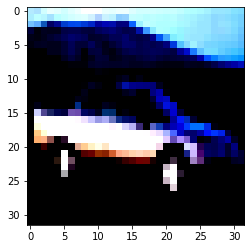

In [75]:
# Normalized Image
plt.imshow(tt.Normalize(mean,std)(dataset[5000][0]).permute((1, 2 ,0)))

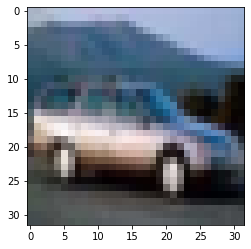

In [76]:
# Original Image
plt.imshow(dataset[5000][0].permute((1, 2 ,0)))

In [77]:
# Creating transforms with multiple tensor transforms

train_tfms = tt.Compose([
    tt.RandomCrop(32, padding = 4, padding_mode = 'reflect'),
    tt.RandomHorizontalFlip(),
    #tt.RandomRotation(degrees=(0, 180)),
    #tt.RandomResizedCrop(256, scale=(0.5, 0.9), ratio = (1, 1)),
    #tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    tt.ToTensor(),
    tt.Normalize(mean,std, inplace= True)
])

valid_tfms = tt.Compose([
    tt.ToTensor(), 
    tt.Normalize(mean, std)
])

In [78]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
val_ds = ImageFolder(data_dir+'/test', valid_tfms)

Next, we can create data loaders for retrieving images in batches. We will use a relatively large batch size of 400 to utilize a larger portion of the GPU RAM.

In [79]:
batch_size = 400

In [80]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 2, pin_memory = True)

Let's take a look at some sample images from the training dataloader. To display the images, we will need to denormalize the pixel values to bring them back into the range of (0, 1).

In [81]:
def denormalize(images, means, stds):
  means = means.reshape(1, 3, 1, 1) 
  stds = stds.reshape(1, 3, 1, 1)
  return images * stds + means

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(images, *(mean, std))
    ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
    break

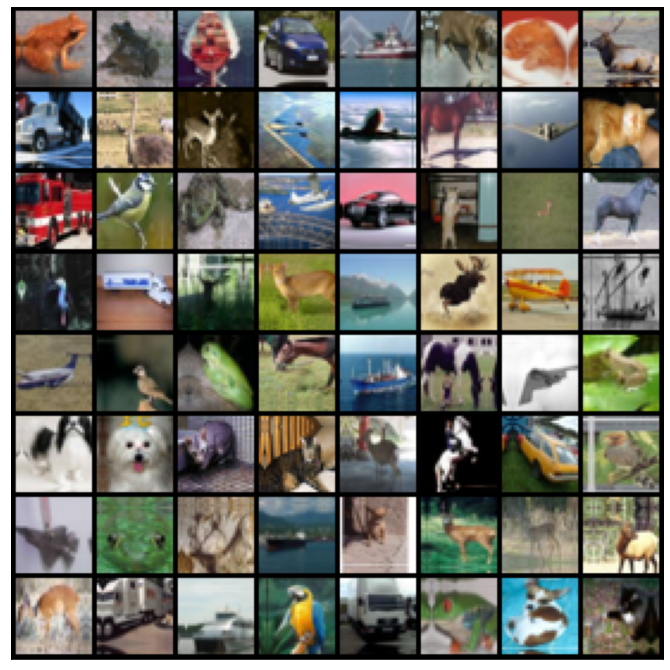

In [82]:
show_batch(train_dl)

# Using a GPU

To seamlessly use a GPU, if one is avialable, we define a couple of helper functions (`get_default_device` and `to_device`) and a helper class `DeviceDataLoader` to move our model and data to the GPU as required.

In [83]:
def get_default_device():
  '''Pick GPU if avaialble, else CPU'''
  if torch.cuda.is_available():
    return torch.device('cuda')

  else:
    return torch.device('cpu')

def to_device(data, device):
  '''Move tensor(s) to chosen device'''
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [84]:
class DeviceDataLoader():
  '''Wrap a data_loader to move data to a device'''
  def __init__(self, data_loader, device):
    self.data_loader = data_loader
    self.device = device

  def __iter__(self):
    '''Yield a batch of data after moving it to a device'''
    for b in self.data_loader:
      yield to_device(b, self.device)

  def __len__(self):
    '''Number of batches'''
    return len(self.data_loader)

In [85]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [86]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# Model with Residual Blocks and Batch Normalization

One of the key changes to our CNN model this time is the addition of the residual block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

In [87]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 3, stride = 1, padding = 1)
    self.relu2 = nn.ReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    return self.relu2(out) + x    # ReLU can be applied before or after adding the input

In [88]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
  out = simple_resnet(images)
  print(out.shape)
  break

torch.Size([400, 3, 32, 32])


In [89]:
del simple_resnet, images, labels
torch.cuda.empty_cache()

This seemingly small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we will add a batch normalization layer, which normalizaes the outputs of the previous layer.

We will use the **ResNet9** architecture.

In [90]:
class ImageClassificationBase(nn.Module):

  def training_step(self, batch):
    """Returns the loss for a batch of training data"""
    images, labels = batch
    out = self(images)                      # Generate predictions
    loss = F.cross_entropy(out, labels)     # Calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)                      # Generate predictions
    loss = F.cross_entropy(out, labels)     # calculate loss
    acc = accuracy(out, labels)             # calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()       # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()          # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print(f'Epoch [{epoch}], last_lr: {result["lrs"][-1]}, train_loss: {result["train_loss"]}, val_loss: {result["val_loss"]}, val_acc: {result["val_acc"]}')


def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [91]:
# Defining a convolutional block for ResNet9

def conv_block(in_channels, out_channels, pool=False):
  layers = [
      nn.Conv2d(in_channels, out_channels, kernel_size= 3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  ]
  if pool:
    layers.append(nn.MaxPool2d(2))

  return nn.Sequential(*layers)

In [92]:
# Extending the ImageClassificationBase class to create the ResNet9 class

class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    # 3 x 32 x 32
    self.conv1 = conv_block(in_channels, 64)    # 64 x 32 x 32
    self.conv2 = conv_block(64, 128, pool = True)    # 128 x 16 x 16
    self.res1 = nn.Sequential(conv_block(128, 128), 
                              conv_block(128, 128))    # 128 x 16 x 16

    self.conv3 = conv_block(128, 256, pool=True)    # 256 x 8 x 8
    self.conv4 = conv_block(256, 512, pool = True)    # 512 x 4 x 4
    self.res2 = nn.Sequential(conv_block(512, 512), 
                              conv_block(512, 512))    # 512 x 4 x 4
    
    self.classifier = nn.Sequential(nn.MaxPool2d(4),   # 512 x 1 x 1
                                    nn.Flatten(),      # 512
                                    nn.Dropout(0.2),    # 512
                                    nn.Linear(512, num_classes))     # 10


  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out


In [93]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# Training the model

Before we train the model, we are going to make a bunch of small but important improvements to our `fit` function:

**Learning rate scheduling:** Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the "**One Cycle Learning Rate Policy**", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs.

**Weight decay:** We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

**Gradient clipping:** Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. 


Let's define a fit_one_cycle function to incorporate these changes. We will also record the learning rate used for each batch.

There are few layers which behave differently while training and evaluation specifically the dropout layer and the batch normalization layer. so when `model.eval()` is there then dropout is no longer applied during evaluation.



In [94]:
from IPython.core.history import HistoryManager
@torch.no_grad()
def evaluate(model, val_loader):
  '''Evaluate the model's performance on the validation set.'''
  model.eval()    # It tells pytorch that the layers should be put in evaluation mode. There is no randomization in evaluation.
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)


def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

# Defining a function to train the model.

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay = 0, grad_clip = None, opt_func = torch.optim.SGD):
  '''Train the model using gradient descent.'''
  torch.cuda.empty_cache()  # clearing the GPU cache
  history = []

  # set up custom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)

  # set up one-cycle learning rate scheduler
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                  max_lr, 
                                                  epochs = epochs, 
                                                  steps_per_epoch=len(train_loader))
  

  for epoch in range(epochs):
    # Training phase
    model.train()    # It tells pytorch that we are training the model. There is randomization in training.
    train_losses = []
    lrs = []
    for batch in train_loader:
      loss = model.training_step(batch) # yet to define the training_step function.
      train_losses.append(loss)
      loss.backward()

      # Gradient clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      # Gradient descent is being performed  
      optimizer.step()
      optimizer.zero_grad()

      # Record and update learning rate
      lrs.append(get_lr(optimizer))
      scheduler.step()

    # validation phase
    result = evaluate(model, val_loader) # not yet defined.
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)

  return history



In [95]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 2.3003547191619873, 'val_acc': 0.09942308068275452}]

We are now ready to train our model. Instead of SGD (stochastic gradient descent), we will use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training.

In [96]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [97]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         grad_clip = grad_clip,
                         weight_decay = weight_decay,
                         opt_func = opt_func
                         )

Epoch [0], last_lr: 0.0015095949829120082, train_loss: 1.4720481634140015, val_loss: 1.1871589422225952, val_acc: 0.5812500715255737
Epoch [1], last_lr: 0.004351799465045991, train_loss: 0.9974619746208191, val_loss: 0.946506142616272, val_acc: 0.6797115802764893
Epoch [2], last_lr: 0.00759224317083135, train_loss: 0.875548243522644, val_loss: 1.3488835096359253, val_acc: 0.6083653569221497
Epoch [3], last_lr: 0.009709503120090498, train_loss: 0.7548651695251465, val_loss: 0.8762637972831726, val_acc: 0.717596173286438
Epoch [4], last_lr: 0.009944154354509118, train_loss: 0.6175094246864319, val_loss: 0.6898817420005798, val_acc: 0.7684615850448608
Epoch [5], last_lr: 0.009504846320134737, train_loss: 0.5278225541114807, val_loss: 0.6940439939498901, val_acc: 0.7709616422653198
Epoch [6], last_lr: 0.008665264698111694, train_loss: 0.47084733843803406, val_loss: 0.6162332892417908, val_acc: 0.801634669303894
Epoch [7], last_lr: 0.00750001, train_loss: 0.40835127234458923, val_loss: 0.50

Out model trained to over 90% accuracy in under 10 minutes. 



1.   94% accuracy in under 10 minutes (easy)
2.   90% accuracy in under 2.5 minutes (intermediate)
3.   94% accuracy in under 5 minutes (hard)

Lets Plot the validation set accuracies to study how the model improves over time.



In [98]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs No. of epochs');
  


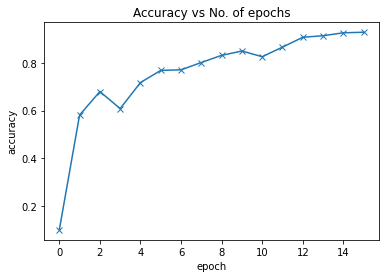

In [99]:
plot_accuracies(history)

In [101]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('Loss')
  plt.legend(['Training', 'validation'])
  plt.title('Loss vs No. of epochs')


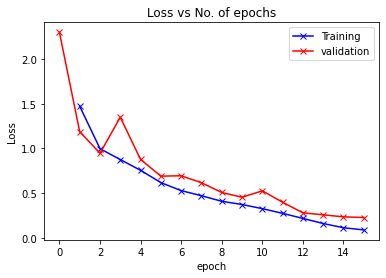

In [102]:
plot_losses(history)

In [103]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning Rate')
  plt.title('Learning Rate vs. Batch No.');

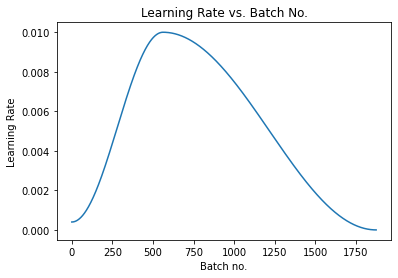

In [104]:
plot_lrs(history)

In [105]:
def predict_image(img, model):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  # Pick index with highest probability
  _, preds = torch.max(yb, dim = 1)
  # Retrieve the class label
  return dataset.classes[preds[0].item()]

Label:  airplane , Predicted:  airplane


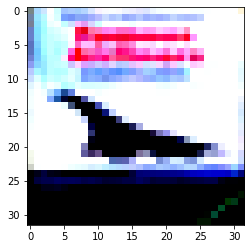

In [106]:
img, label = val_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label: ', train_ds.classes[label], ', Predicted: ', predict_image(img, model))

# Saving the model

In [107]:
torch.save(model.state_dict(), 'CIFAR9_RESNET9.pth')